In [1]:
import pandas as pd
from tqdm import tqdm
import os
import openai
import numpy as np
import pickle as pk
import seaborn as sns
import matplotlib.pyplot as plt
import json
keys = json.load(open("keys.json"))
os.environ["OPENAI_API_KEY"]=keys["OPENAI_API_KEY"]
openai.api_key = os.environ.get("OPENAI_API_KEY")
import together
os.environ["TOGETHER_API_KEY"]=keys["TOGETHER_API_KEY"]
together.api_key = os.environ.get("TOGETHER_API_KEY")
# pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('future.no_silent_downcasting', True)

to do:
1. Define a statistical way to reject features
2. Why AUT is not optimal
3. Define a measure of clumping - compare in default vs unrelated vs related 
4. Think of models, test some models

In [2]:
def together_call(prompt: str) -> str:
    """
    Calls TOGETHER API with input prompt.
    """
    output = together.Complete.create(
        prompt=prompt,
        model="meta-llama/Llama-3-70b-chat-hf",
        temperature=0,
        max_tokens=512,
        stop=[")", ")```"],
    )
    text_output = output["choices"][0]["text"].replace("assistant", "").replace("\n", "").replace("```", "")
    match = re.split(r"\)+", text_output, maxsplit=1)
    if match:
        return match[0]
    return text_output

def summarise_cluster(cluster_texts):
    text = ",".join(cluster_texts)
    # prompt = f"Summarise the sentences with a single theme phrase. Also output the mean similarity of the sentences on a scale of 1-5. Output format: (theme comma similarity) in round brackets (). Do not output any other words or text.\nSentences: [{text}]."
    prompt = f"Summarise the sentences with a single theme phrase. Output format: (theme). Do not output any other words or text.\nSentences: [{text}]."
    
    try:
        answer = together_call(prompt)
    except Exception as e:
        print("Error:", e)
        answer = "NA"
    # return str(len(cluster_texts)) + ", " + answer.replace("(", "")
    return answer.replace("(", "")

In [3]:
def gpt_call(prompt: str, model: str, temp: float) -> str:
    '''
    Calls OPENAI API with input and system prompt.
    '''
    response = openai.OpenAI().chat.completions.create(
        model = model,
        temperature = temp,
        max_tokens = 512,
        stop = ["]", "].", "]\n", "],"],
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content

def get_features(texts, task):
    for text in tqdm(texts):
        if text in text_to_features[task]:
            continue
        
        if task == "autbrick":
            prompt = f'''I have responses for alternate uses of a brick. 
        For the response {text}, give me and 0 (no) / 1 (yes) label for each of the following 130 features as a binary comma-separated list in square braces '[]':

        1. Can hold weight
        2. Provides elevation
        3. Used for construction
        4. Serves as a tool
        5. Used for organization
        6. Provides insulation
        7. Used in outdoor environments
        8. Provides seating
        9. Decorative use
        10. Involves stacking
        11. Aids in cooking
        12. Works as an anchor
        13. For crafting/art
        14. Offers protection/security
        15. Used for grinding/crushing
        16. Functions as a toy/game
        17. Involves digging
        18. For holding objects
        19. Provides heat retention
        20. Adds balance/stability
        21. Garden/landscaping use
        22. Supports furniture
        23. Used as a weapon
        24. Holds or displays items
        25. Sports-related
        26. Simulates real-world items (like food)
        27. Serves as a fence/barrier
        28. DIY home improvement
        29. Functions as a paperweight
        30. Used as a path or pavement
        31. Holds plants
        32. Provides traction
        33. Used as storage
        34. Supports cleaning
        35. Acts as a boundary
        36. Can be customized/painted
        37. Emulates animal toys/enrichment
        38. Cooking utensil function
        39. Makes sound (percussion)
        40. Used in fitness/weight training
        41. Marks boundaries or areas
        42. Provides seating/elevation for small tasks
        43. Indoor use
        44. Outdoor use
        45. Heat resistance
        46. Functions in protection
        47. Provides structural support
        48. Absorbs or transfers heat
        49. Used as art canvas
        50. Child-friendly toy
        51. Used as a foundation
        52. Can be glued or stuck together
        53. Holds liquids
        54. Used in teaching/education
        55. Historical/cultural significance
        56. Provides warmth
        57. Decorative lighting/illumination
        58. Fire resistance
        59. Functions as a miniature model
        60. Used in construction training
        61. Used for meditation or spiritual purposes
        62. Provides ground preparation for surfaces
        63. Temporary usage only
        64. Lightweight action
        65. Can be hollowed out or carved
        66. Can be heated or frozen
        67. Involves fine detail work (carving, engraving)
        68. Used for water retention/conservation
        69. For animal shelter/enrichment
        70. Functions as a weight/resistance tool
        71. Symbolic purpose (e.g., memorial)
        72. Mold for other materials
        73. Holds or organizes paper/documents
        74. Marks location or property
        75. Provides traction in icy/slippery conditions
        76. Supports outdoor play or games
        77. Used in gardening/planting
        78. Food-related preparation use
        79. Fits together modularly
        80. Urban infrastructure element
        81. Used as a temporary stand
        82. Helps prevent movement
        83. Assists in cutting/slicing
        84. Can be a solid color or painted
        85. Used for creative DIY projects
        86. Repurposed from another use
        87. Related to home security
        88. Works as a sound buffer or amplifier
        89. Holds fragile objects in place
        90. Non-functional decorative purpose
        91. Has industrial uses (e.g., for machines)
        92. Mimics natural stones/rocks
        93. Provides resistance to wear or pressure
        94. Maintains or marks temperature
        95. Acts as a table stabilizer
        96. Helps keep items organized
        97. Compatible with glue or adhesives
        98. Can withstand pressure or impact
        99. Affects airflow or ventilation
        100. Can be set up or removed easily
        101. Heavy or dense
        102. Lightweight
        103. Rough surface
        104. Smooth surface
        105. Porous material
        106. Water-resistant
        107. Fireproof
        108. Heat-absorbing
        109. Conductive (e.g., heat or electricity)
        110. Brittle or prone to shattering
        111. Durable/hard-wearing
        112. Flexible (can be shaped/molded)
        113. Sharp edges
        114. Rounded edges
        115. High friction surface (non-slip)
        116. Low friction surface (slippery)
        117. Resistant to erosion or weathering
        118. Reflective or shiny
        119. Opaque (does not allow light through)
        120. Translucent (allows some light through)
        121. Breakable into smaller pieces
        122. Contains color naturally (e.g., reddish-brown for clay bricks)
        123. Susceptible to cracking under pressure
        124. Absorbs moisture
        125. Non-magnetic
        126. Resists compression
        127. Can be compacted or layered
        128. Reactive to chemicals (e.g., lime in cement reacts with water)
        129. High thermal mass (retains temperature for long periods)
        130. Tends to expand or contract with temperature changes'''
        elif task == "autpaperclip":
            prompt = f'''I have responses for alternate uses of a paperclip. 
            For the response {text}, give me and 0 (no) / 1 (yes) label for each of the following 130 features as a binary comma-separated list in square braces '[]':

            1. Acts as a Holder
            2. Used in Crafting
            3. For Decoration
            4. Organizational Tool
            5. For Jewelry Making
            6. Emergency Tool
            7. Hair Accessories
            8. Cleaning Tool
            9. Makeshift Key
            10. Electrical Conductor
            11. Can Be Bent
            12. Temporary Repair
            13. Fashion Accessory
            14. For Paper Binding
            15. Medical Use
            16. Unclogging Tool
            17. Tool for Marking
            18. Household Tool
            19. Cooking Aid
            20. Experimental Tool
            21. Writing Aid
            22. Educational Use
            23. Hanging or Mounting
            24. Game or Toy
            25. Practical Art
            26. Clothes Fastening
            27. Home Decor
            28. Stress Relief
            29. Plant Support
            30. Signaling Device
            31. Key Management
            32. Tool for Threading
            33. Used in Repair
            34. Flexible Material
            35. Portable Size
            36. Utilizes Magnetic Properties
            37. Camping Gear
            38. Simple Machine Element
            39. Can Be Sharpened
            40. Battery Holder
            41. Craft Embellishment
            42. Medical Instrument
            43. Fixing Tools
            44. Engages in Symbolism
            45. Instrument for Piercing
            46. Microwave Safe
            47. For Binding Documents
            48. For Labeling
            49. Capable of Locking
            50. Can Be Combined with Other Tools
            51. Functions as a Marker
            52. Utilized in Outdoor Activities
            53. Can Conduct Heat
            54. Organizing Tool for Cables
            55. Stringing Capability
            56. Can Open Small Objects
            57. Home Repair Utility
            58. Reusability
            59. Holds Shape Under Pressure
            60. Packaging Utility
            61. Decoration for Holidays
            62. Aids in Food Preservation
            63. Mechanical Use
            64. Unsticking Small Items
            65. Suitable for Detangling
            66. Can Hold a Magnetic Charge
            67. Scales Down for Miniature Models
            68. Works as a Fastener
            69. Acts as a Divider
            70. Fine Motor Tool
            71. Works for Beadwork
            72. Aids in Safety
            73. Serves as a Scraper
            74. Appealing to Kids
            75. Connects Objects
            76. Can Be Painted
            77. Useful in Electronics
            78. Suitable for Weight Bearing
            79. Utilized in Sculpture
            80. Nonpermanent Tool
            81. Helpful for Packing
            82. Pin-like Functionality
            83. Can Be Decorated
            84. Adaptable Shape
            85. Clothesline Clip
            86. Aesthetic Enhancer
            87. Includes a Loop
            88. Can Function as a Wedge
            89. Helps in Counting
            90. Secure Closure
            91. Eyelet Creation
            92. Helps with Insertion
            93. Functions as a Lever
            94. For Bag Organization
            95. Suitable for Knotting
            96. Used for Pinning
            97. Simple Adhesive Substitute
            98. Building Material
            99. Good for Sorting
            100. Acts as an Engraving Tool
            101. Corrosion-Resistant
            102. Flexible Ends
            103. Non-toxic Coating
            104. High Reflectivity
            105. Low Reflectivity
            106. Colorful
            107. Transparent
            108. Opaque
            109. High Friction
            110. Non-flammable
            111. Scratch-Resistant
            112. Break-Resistant
            113. UV-Resistant
            114. Hypoallergenic
            115. Non-reactive
            116. Eco-Friendly Material
            117. Compact Shape
            118. Elasticity
            119. Sharp Ends
            120. Rounded Points
            121. Springy
            122. Lightweight
            123. Rust-Prone
            124. Sturdy Core
            125. Polished Finish
            126. Textile Friendly
            127. Dual-Layer Coating
            128. Minimal Deformation
            129. Smooth surface
            130. Ductile'''
        elif task == "vf":
            prompt = f'''For the animal {text}, give me and 0 (no) / 1 (yes) label for each of the following 130 features as a binary comma-separated list in square braces '[]':

            1. Is mammal
            2. Is bird
            3. Is insect
            4. Is reptile
            5. Is amphibian
            6. Is fish
            7. Is carnivore
            8. Is herbivore
            9. Is omnivore
            10. Has fur
            11. Has feathers
            12. Has scales
            13. Has exoskeleton
            14. Has beak
            15. Has claws
            16. Has whiskers
            17. Has horns
            18. Has antlers
            19. Has tusks
            20. Has wings
            21. Has tail
            22. Can fly
            23. Can swim
            24. Can climb
            25. Can dig
            26. Can jump
            27. Is nocturnal
            28. Is diurnal
            29. Has more than four limbs
            30. Lives in water
            31. Lives in trees
            32. Lives underground
            33. Lives on land
            34. Lays eggs
            35. Gives birth
            36. Has scales
            37. Has a long neck
            38. Is venomous
            39. Is domesticated
            40. Lives in groups
            41. Is solitary
            42. Builds nests
            43. Is migratory
            44. Has social hierarchy
            45. Uses tools
            46. Shows intelligence
            47. Communicates vocally
            48. Has camouflage
            49. Has stripes
            50. Has spots
            51. Can change color
            52. Is endangered
            53. Is commonly kept as a pet
            54. Is used in farming
            55. Is hunted by humans
            56. Is used for food by humans
            57. Is found in zoos
            58. Is capable of mimicry
            59. Has echolocation
            60. Is warm-blooded
            61. Is cold-blooded
            62. Has a long lifespan
            63. Is capable of regrowth
            64. Has specialized hunting techniques
            65. Is known for speed
            66. Is known for strength
            67. Has a specialized diet
            68. Is migratory
            69. Can hibernate
            70. Has a backbone
            71. Is marsupial
            72. Is placental
            73. Is monotreme
            74. Is flightless
            75. Has webbed feet
            76. Is known for intelligence
            77. Is a scavenger
            78. Is territorial
            79. Is native to Africa
            80. Is native to Asia
            81. Is native to North America
            82. Is native to South America
            83. Is native to Australia
            84. Is native to Europe
            85. Is found in deserts
            86. Is found in forests
            87. Is found in oceans
            88. Is found in grasslands
            89. Is found in mountains
            90. Has a mane
            91. Has a crest
            92. Has gills
            93. Is bioluminescent
            94. Is used in scientific research
            95. Is a predator
            96. Is prey for larger animals
            97. Is capable of parental care
            98. Lives in a burrow
            99. Is a pollinator
            100. Can tolerate extreme temperatures
            101. Exhibits seasonal color changes
            102. Migrates seasonally
            103. Is active during dawn or dusk (crepuscular)
            104. Produces pheromones for communication
            105. Lives symbiotically with other species
            106. Is a parasite
            107. Is a host for parasites
            108. Is bi-parental (both parents care for offspring)
            109. Displays mating rituals
            110. Has specialized courtship behavior
            111. Exhibits territorial marking
            112. Is associated with mythology or folklore
            113. Is endangered
            114. Exhibits altruistic behavior
            115. Is a keystone species in its ecosystem
            116. Uses burrows or dens for shelter
            117. Can regenerate body parts
            118. Is raised in captivity or farms
            119. Has unique reproductive strategies (e.g., asexual reproduction)
            120. Hibernates during winter
            121. Has a role in biological pest control
            122. Has distinct seasonal breeding cycles
            123. Forms a symbiotic relationship with plants (e.g., pollination)
            124. Uses specific vocalizations to communicate
            125. Is a flagship species (conservation symbol)
            126. Can be trained or tamed by humans
            127. Displays warning coloration
            128. Has flippers
            129. Has compound eyes
            130. Has a segmented body'''
        
        cnt = 0
        while True:
            try:
                response = gpt_call(prompt, "gpt-4o", 0)
            except Exception as e:
                print("Error:", e)
                response = 'NA'
        
            response = response[response.find("[") + 1:]
            print(text, response.count(","))
            print(response)
            cnt += 1
            if response.count(",") == 129 or cnt == 3:
                break

        text_to_features[task][text] = response

In [4]:
data = pd.read_csv("../csvs/data_humans_allresponses.csv")

data_autbrick = data[data["task"] == 2].reset_index(drop=True)
data_autpaperclip = data[data["task"] == 3].reset_index(drop=True)
data_vf = data[data["task"] == 1].reset_index(drop=True)

texts_autbrick = data_autbrick["response"].unique().tolist()

texts_autpaperclip = data_autpaperclip["response"].unique().tolist()
texts_vf = data_vf["response"].unique().tolist()

tasks = ["autbrick", "autpaperclip", "vf"]

In [ ]:
# dict1 = pk.load(open("brick_features_1_reducedandupdated.pk", "rb"))
# dict2 = pk.load(open("brick_features_2_reducedandupdated.pk", "rb"))
# dict3 = pk.load(open("brick_features_3_reducedandupdated.pk", "rb"))
# dict4 = pk.load(open("brick_features_4_reducedandupdated.pk", "rb"))
# pk.dump(dict1 | dict2 | dict3 | dict4, open("autbrick_features.pk", "wb"))

# dict1 = pk.load(open("paperclip_features_1_reducedandupdated.pk", "rb"))
# dict2 = pk.load(open("paperclip_features_2_reducedandupdated.pk", "rb"))
# dict3 = pk.load(open("paperclip_features_3_reducedandupdated.pk", "rb"))
# dict4 = pk.load(open("paperclip_features_4_reducedandupdated.pk", "rb"))
# pk.dump(dict1 | dict2 | dict3 | dict4, open("autpaperclip_features.pk", "wb"))

## Analyse features

In [6]:
def get_featuredf(task):
    featuredict = pk.load(open(f"{task}_features.pk", "rb"))
    featuredf = pd.DataFrame.from_dict(featuredict, orient='index')
    if task == "vf":
        to_remove = ["dog cat monkey rat mouse hamster crocodile lion zebra giraffe elephant beaver hare rabbit parrot heron duck", "cow bull chicken dog cat shepherd", "cat dog lion tiger parrot monkey human food cows milk eggs hamster", "monkey dog cat guinea pig rabbit horsecow duck goat chicken elephant giraffe meerkat", " store", "tit", "python", "mammal", "le", "okay", "sea animals", "land animals", "mammals", "diversity", "birds", "unicorn", "dragon", "bird", "man", "pets"]
        featuredf = featuredf.loc[~featuredf.index.isin(to_remove)]
    featuredf = featuredf.replace({'True': 1, 'True.': 1, 'False': 0, 'False.': 0})
    # featuredf = featuredf[featuredf.applymap(lambda x: isinstance(x, int)).all(axis=1)]
    featuredf = featuredf[featuredf.apply(lambda row: row.map(lambda x: isinstance(x, int)).all(), axis=1)]
    return featuredf, list(featuredf.columns)

vf_featuredf, vf_featurecols = get_featuredf("vf")
autbrick_featuredf, autbrick_featurecols = get_featuredf("autbrick")
autpaperclip_featuredf, autpaperclip_featurecols = get_featuredf("autpaperclip")

In [7]:
vf_featuredf

,feature_Is mammal,feature_Is bird,feature_Is insect,feature_Is reptile,feature_Is amphibian,feature_Is fish,feature_Is carnivore,feature_Is herbivore,feature_Is omnivore,feature_Has fur,feature_Has feathers,feature_Has scales,feature_Has exoskeleton,feature_Has beak,feature_Has claws,feature_Has whiskers,feature_Has horns,feature_Has antlers,feature_Has tusks,feature_Has wings,feature_Has tail,feature_Can fly,feature_Can swim,feature_Can climb,feature_Can dig,feature_Can jump,feature_Is nocturnal,feature_Is diurnal,feature_Has more than four limbs,feature_Lives in water,feature_Lives in trees,feature_Lives underground,feature_Lives on land,feature_Lays eggs,feature_Gives birth,feature_Has a long neck,feature_Is venomous,feature_Is domesticated,feature_Lives in groups,feature_Is solitary,feature_Builds nests,feature_Is migratory,feature_Has social hierarchy,feature_Uses tools,feature_Shows intelligence,feature_Communicates vocally,feature_Has camouflage,feature_Has stripes,feature_Has spots,feature_Can change color,feature_Is endangered,feature_Is commonly kept as a pet,feature_Is used in farming,feature_Is hunted by humans,feature_Is used for food by humans,feature_Is found in zoos,feature_Is capable of mimicry,feature_Has echolocation,feature_Is warm-blooded,feature_Is cold-blooded,feature_Has a long lifespan,feature_Is capable of regrowth,feature_Has specialized hunting techniques,feature_Is known for speed,feature_Is known for strength,feature_Has a specialized diet,feature_Can hibernate,feature_Has a backbone,feature_Is marsupial,feature_Is placental,feature_Is monotreme,feature_Is flightless,feature_Has webbed feet,feature_Is known for intelligence,feature_Is a scavenger,feature_Is territorial,feature_Is native to Africa,feature_Is native to Asia,feature_Is native to North America,feature_Is native to South America,feature_Is native to Australia,feature_Is native to Europe,feature_Is found in deserts,feature_Is found in forests,feature_Is found in oceans,feature_Is found in grasslands,feature_Is found in mountains,feature_Has a mane,feature_Has a crest,feature_Has gills,feature_Is bioluminescent,feature_Is used in scientific research,feature_Is a predator,feature_Is prey for larger animals,feature_Is capable of parental care,feature_Lives in a burrow,feature_Is a pollinator,feature_Can tolerate extreme temperatures,feature_Exhibits seasonal color changes,feature_Migrates seasonally,feature_Is active during dawn or dusk (crepuscular),feature_Produces pheromones for communication,feature_Lives symbiotically with other species,feature_Is a parasite,feature_Is a host for parasites,feature_Is bi-parental (both parents care for offspring),feature_Displays mating rituals,feature_Has specialized courtship behavior,feature_Exhibits territorial marking,feature_Is associated with mythology or folklore,feature_Exhibits altruistic behavior,feature_Is a keystone species in its ecosystem,feature_Uses burrows or dens for shelter,feature_Can regenerate body parts,feature_Is raised in captivity or farms,"feature_Has unique reproductive strategies (e.g., asexual reproduction)",feature_Hibernates during winter,feature_Has a role in biological pest control,feature_Has distinct seasonal breeding cycles,"feature_Forms a symbiotic relationship with plants (e.g., pollination)",feature_Uses specific vocalizations to communicate,feature_Is a flagship species (conservation symbol),feature_Can be trained or tamed by humans,feature_Displays warning coloration,feature_Has flippers,feature_Has compound eyes,feature_Has a segmented body
dog,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0
cat,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,

In [8]:
autbrick_featuredf

,feature_Can hold weight,feature_Provides elevation,feature_Is used for construction,feature_Can serve as a tool,feature_Is used for organization,feature_Provides insulation,feature_Is suitable for outdoor environments,feature_Provides seating,feature_Is used for decoration,feature_Involves stacking,feature_Aids in cooking,feature_Can work as an anchor,feature_Is used for crafting or art,feature_Offers protection or security,feature_Is used for grinding or crushing,feature_Can function as a toy or game,feature_Involves digging,feature_Holds objects,feature_Provides heat retention,feature_Adds balance or stability,feature_Is used in gardening or landscaping,feature_Supports furniture,feature_Can be used as a weapon,feature_Holds or displays items,feature_Is related to sports,"feature_Simulates real-world items (e.g., food)",feature_Is used as a fence or barrier,feature_Assists in DIY home improvement,feature_Functions as a paperweight,feature_Is used as a path or pavement,feature_Holds plants,feature_Provides traction,feature_Is used for storage,feature_Supports cleaning,feature_Acts as a boundary,feature_Can be customized or painted,feature_Emulates animal toys or enrichment,feature_Functions as a cooking utensil,feature_Produces sound (percussion),feature_Is used in fitness or weight training,feature_Marks boundaries or areas,feature_Provides seating or elevation for small tasks,feature_Is suitable for indoor use,feature_Is suitable for outdoor use,feature_Resists heat,feature_Functions in protection,feature_Provides structural support,feature_Absorbs or transfers heat,feature_Is used as an art canvas,feature_Functions as a child-friendly toy,feature_Acts as a foundation,feature_Can be glued or stuck together,feature_Holds liquids,feature_Is used in teaching or education,feature_Has historical or cultural significance,feature_Provides warmth,feature_Is used for decorative lighting or illumination,feature_Resists fire,feature_Functions as a miniature model,feature_Is used in construction training,feature_Supports meditation or spiritual purposes,feature_Prepares the ground for surfaces,feature_Is suitable for temporary usage,feature_Enables lightweight action,feature_Can be hollowed out or carved,feature_Is heated or frozen,"feature_Involves fine detail work (e.g., carving, engraving)",feature_Retains or conserves water,feature_Provides animal shelter or enrichment,feature_Functions as a weight or resistance tool,"feature_Has symbolic purpose (e.g., memorial)",feature_Acts as a mold for other materials,feature_Holds or organizes paper or documents,feature_Marks locations or property,feature_Provides traction in icy or slippery conditions,feature_Supports outdoor play or games,feature_Is used in gardening or planting,feature_Assists in food preparation,feature_Fits together modularly,feature_Is used as an urban infrastructure element,feature_Functions as a temporary stand,feature_Helps prevent movement,feature_Assists in cutting or slicing,feature_Can be a solid color or painted,feature_Is used for creative DIY projects,feature_Is repurposed from another use,feature_Relates to home security,feature_Buffers or amplifies sound,feature_Holds fragile objects in place,feature_Is used for non-functional decorative purposes,"feature_Has industrial uses (e.g., for machines)",feature_Mimics natural stones or rocks,feature_Resists wear or pressure,feature_Maintains or marks temperature,feature_Stabilizes tables,feature_Helps keep items organized,feature_Is compatible with glue or adhesives,feature_Withstands pressure or impact,feature_Affects airflow or ventilation,feature_Is easy to set up or remove,feature_Is heavy or dense,feature_Is lightweight,feature_Has a rough surface,feature_Has a smooth surface,feature_Is made of porous material,feature_Resists water,feature_Is fireproof,feature_Absorbs heat,feature_Conducts heat or electricity,feature_Is brittle or prone to shattering,feature_Is durable or hard-wearing,feature_Is flexible and 

In [9]:
autpaperclip_featuredf

,feature_Acts as a holder,feature_Is used in crafting,feature_Is for decoration,feature_Functions as an organizational tool,feature_Is used for jewelry making,feature_Serves as an emergency tool,feature_Is used as hair accessories,feature_Functions as a cleaning tool,feature_Can serve as a makeshift key,feature_Is an electrical conductor,feature_Can be bent,feature_Is suitable for temporary repair,feature_Is used as a fashion accessory,feature_Functions for paper binding,feature_Is used for medical purposes,feature_Aids in unclogging,feature_Serves as a tool for marking,feature_Acts as a household tool,feature_Assists as a cooking aid,feature_Is used as an experimental tool,feature_Functions as a writing aid,feature_Is utilized for educational purposes,feature_Is used for hanging or mounting,feature_Functions as a game or toy,feature_Supports practical art,feature_Is used for clothes fastening,feature_Is suitable for home decor,feature_Helps with stress relief,feature_Acts as a plant support,feature_Is used as a signaling device,feature_Helps in key management,feature_Functions as a tool for threading,feature_Is used in repair,feature_Is made of flexible material,feature_Comes in a portable size,feature_Utilizes magnetic properties,feature_Is included in camping gear,feature_Functions as a simple machine element,feature_Can be sharpened,feature_Serves as a battery holder,feature_Is used as a craft embellishment,feature_Functions as a medical instrument,feature_Helps in fixing tools,feature_Engages in symbolism,feature_Is used as an instrument for piercing,feature_Is microwave safe,feature_Is used for binding documents,feature_Functions for labeling,feature_Is capable of locking,feature_Can be combined with other tools,feature_Functions as a marker,feature_Is utilized in outdoor activities,feature_Can conduct heat,feature_Functions as an organizing tool for cables,feature_Has stringing capability,feature_Can open small objects,feature_Is a utility for home repair,feature_Supports reusability,feature_Holds shape under pressure,feature_Is used as packaging utility,feature_Functions as a decoration for holidays,feature_Aids in food preservation,feature_Is suitable for mechanical use,feature_Helps with unsticking small items,feature_Is suitable for detangling,feature_Can hold a magnetic charge,feature_Scales down for miniature models,feature_Works as a fastener,feature_Acts as a divider,feature_Functions as a fine motor tool,feature_Works for beadwork,feature_Aids in safety,feature_Serves as a scraper,feature_Is appealing to kids,feature_Connects objects,feature_Can be painted,feature_Is useful in electronics,feature_Is suitable for weight bearing,feature_Is utilized in sculpture,feature_Functions as a nonpermanent tool,feature_Is helpful for packing,feature_Has pin-like functionality,feature_Can be decorated,feature_Has an adaptable shape,feature_Functions as a clothesline clip,feature_Acts as an aesthetic enhancer,feature_Includes a loop,feature_Can function as a wedge,feature_Helps in counting,feature_Provides secure closure,feature_Is used for eyelet creation,feature_Helps with insertion,feature_Functions as a lever,feature_Is used for bag organization,feature_Is suitable for knotting,feature_Is used for pinning,feature_Serves as a simple adhesive substitute,feature_Is used as a building material,feature_Is good for sorting,feature_Acts as an engraving tool,feature_Is corrosion-resistant,feature_Has flexible ends,feature_Has a non-toxic coating,feature_Has high reflectivity,feature_Has low reflectivity,feature_Is colorful,feature_Is transparent,feature_Is opaque,feature_Has high friction,feature_Is non-flammable,feature_Is scratch-resistant,feature_Is break-resistant,feature_Is UV-resistant,feature_Is hypoallergenic,feature_Is non-reactive,feature_Is made of eco-friendly material,feature_Has a compact shape,feature_Shows elasticity,feature_Has sharp ends,feature_Has rounded points,feature_Is springy,feature_Is lightweight,featu

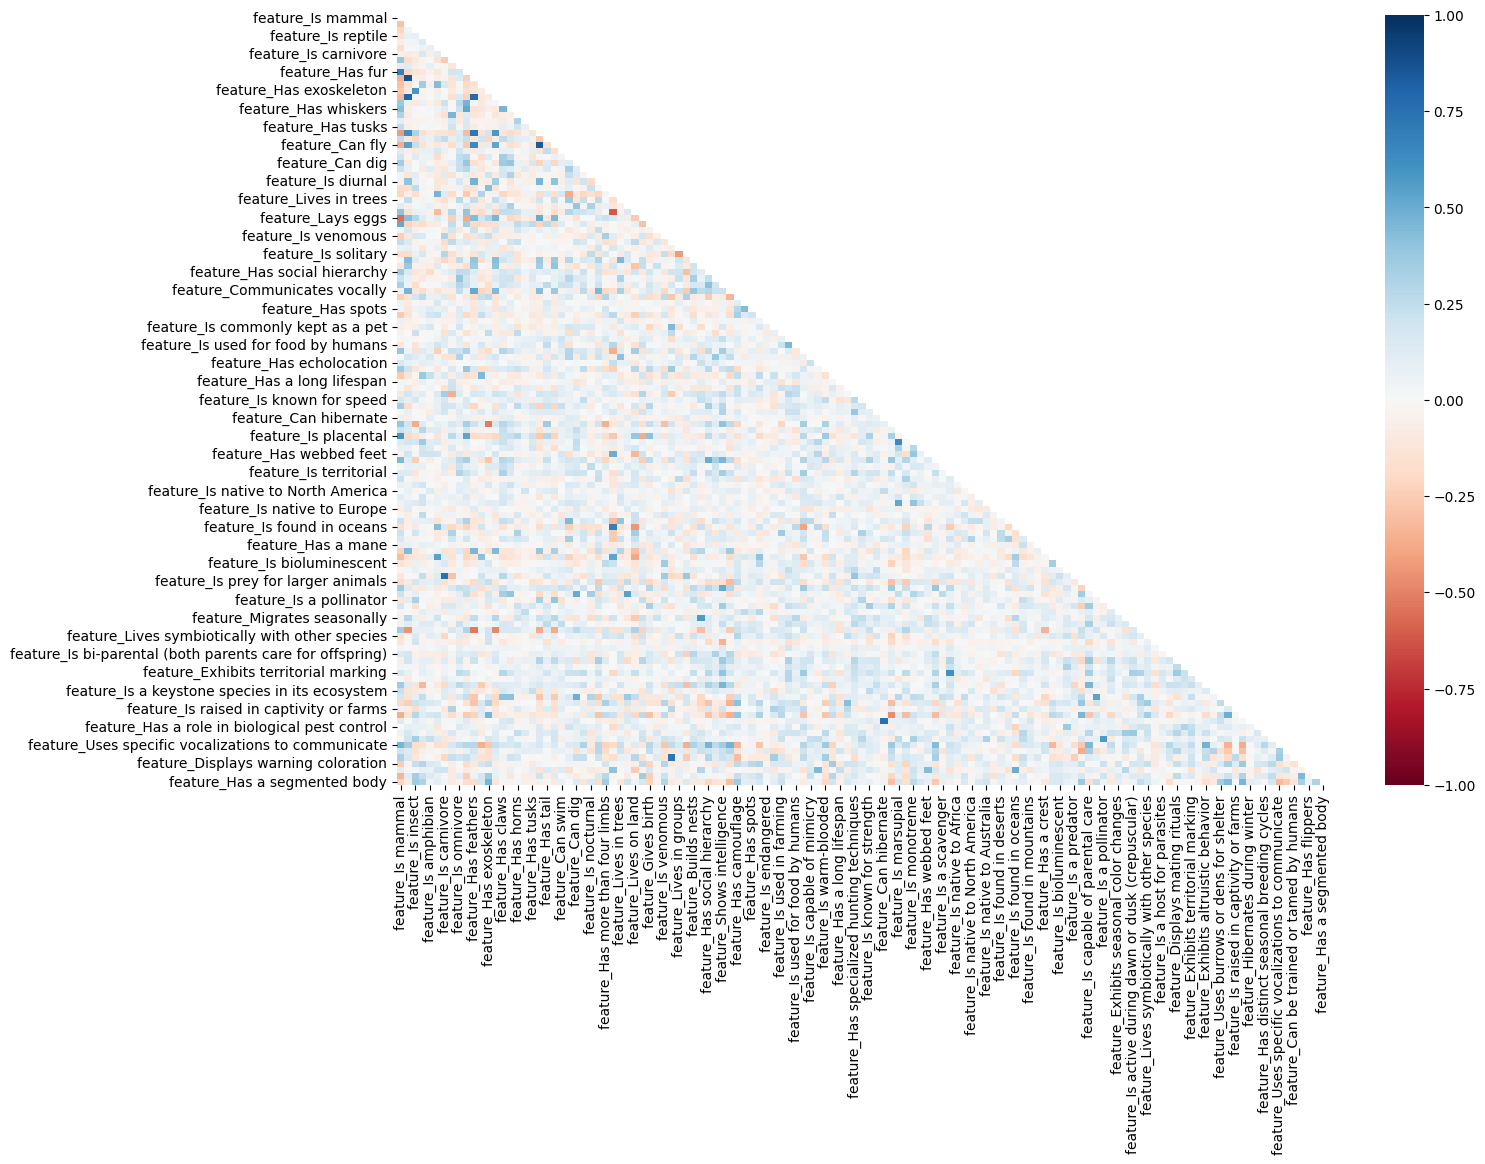

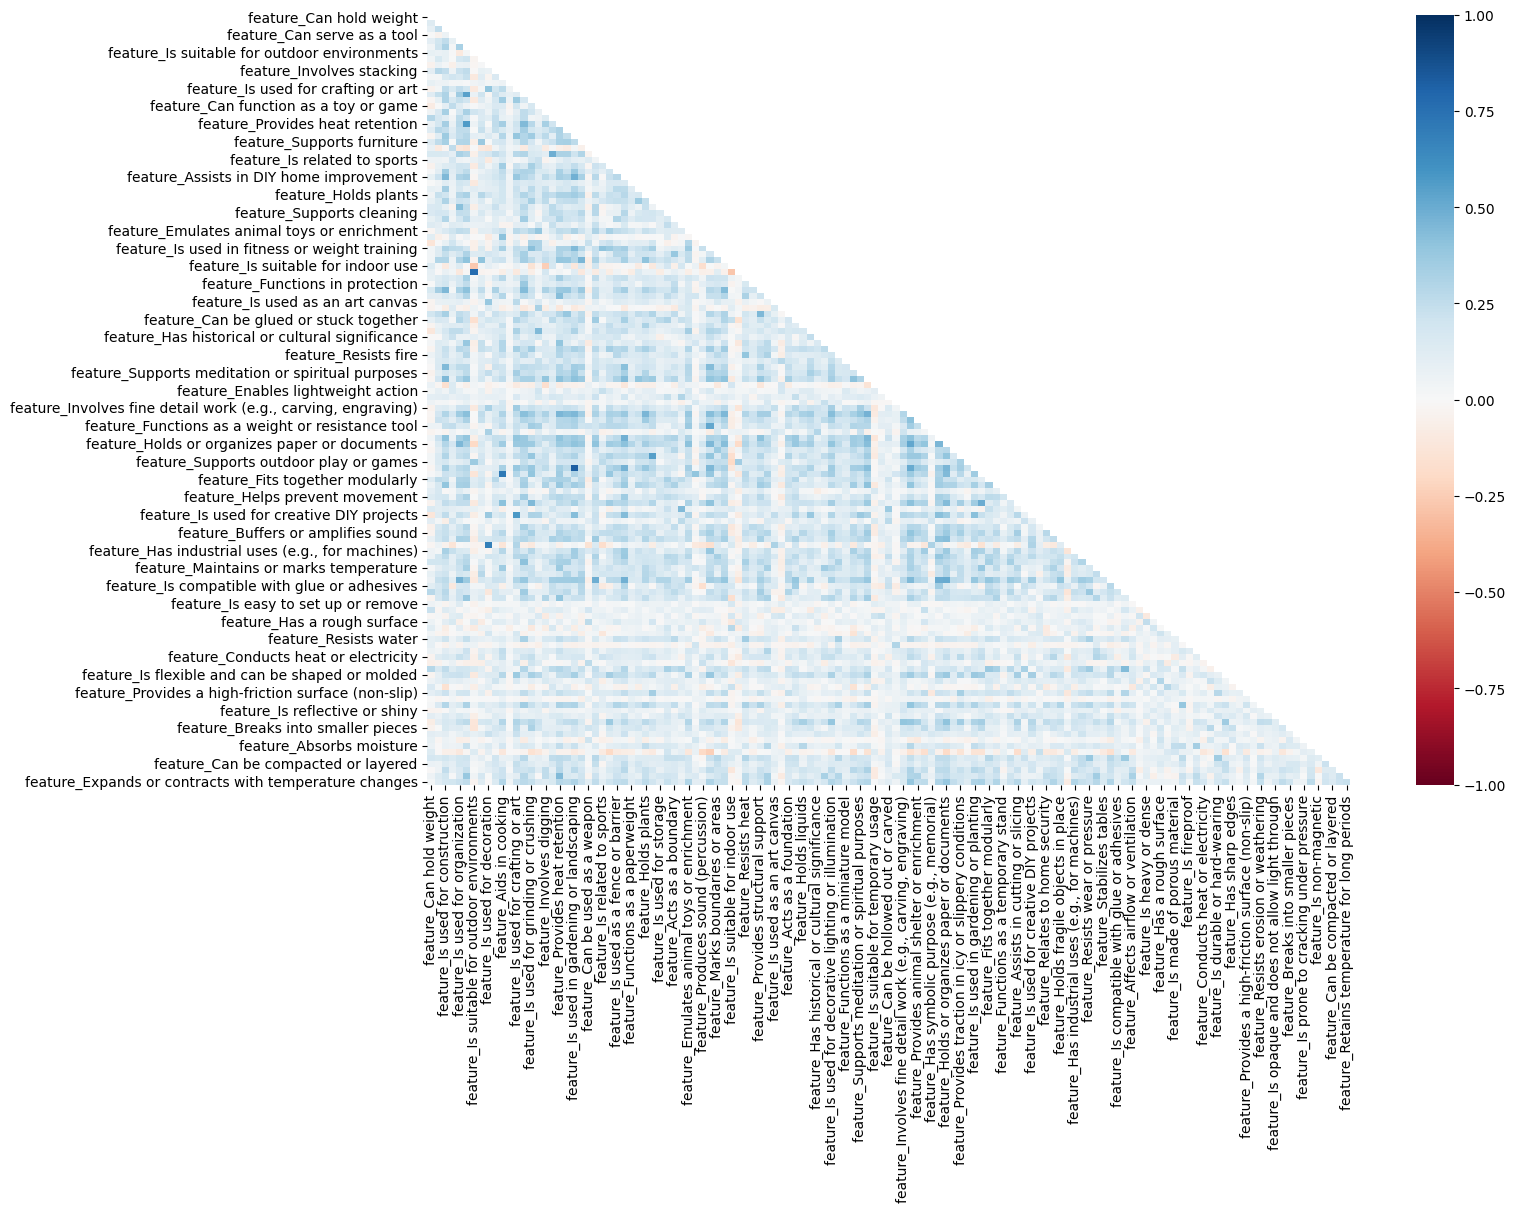

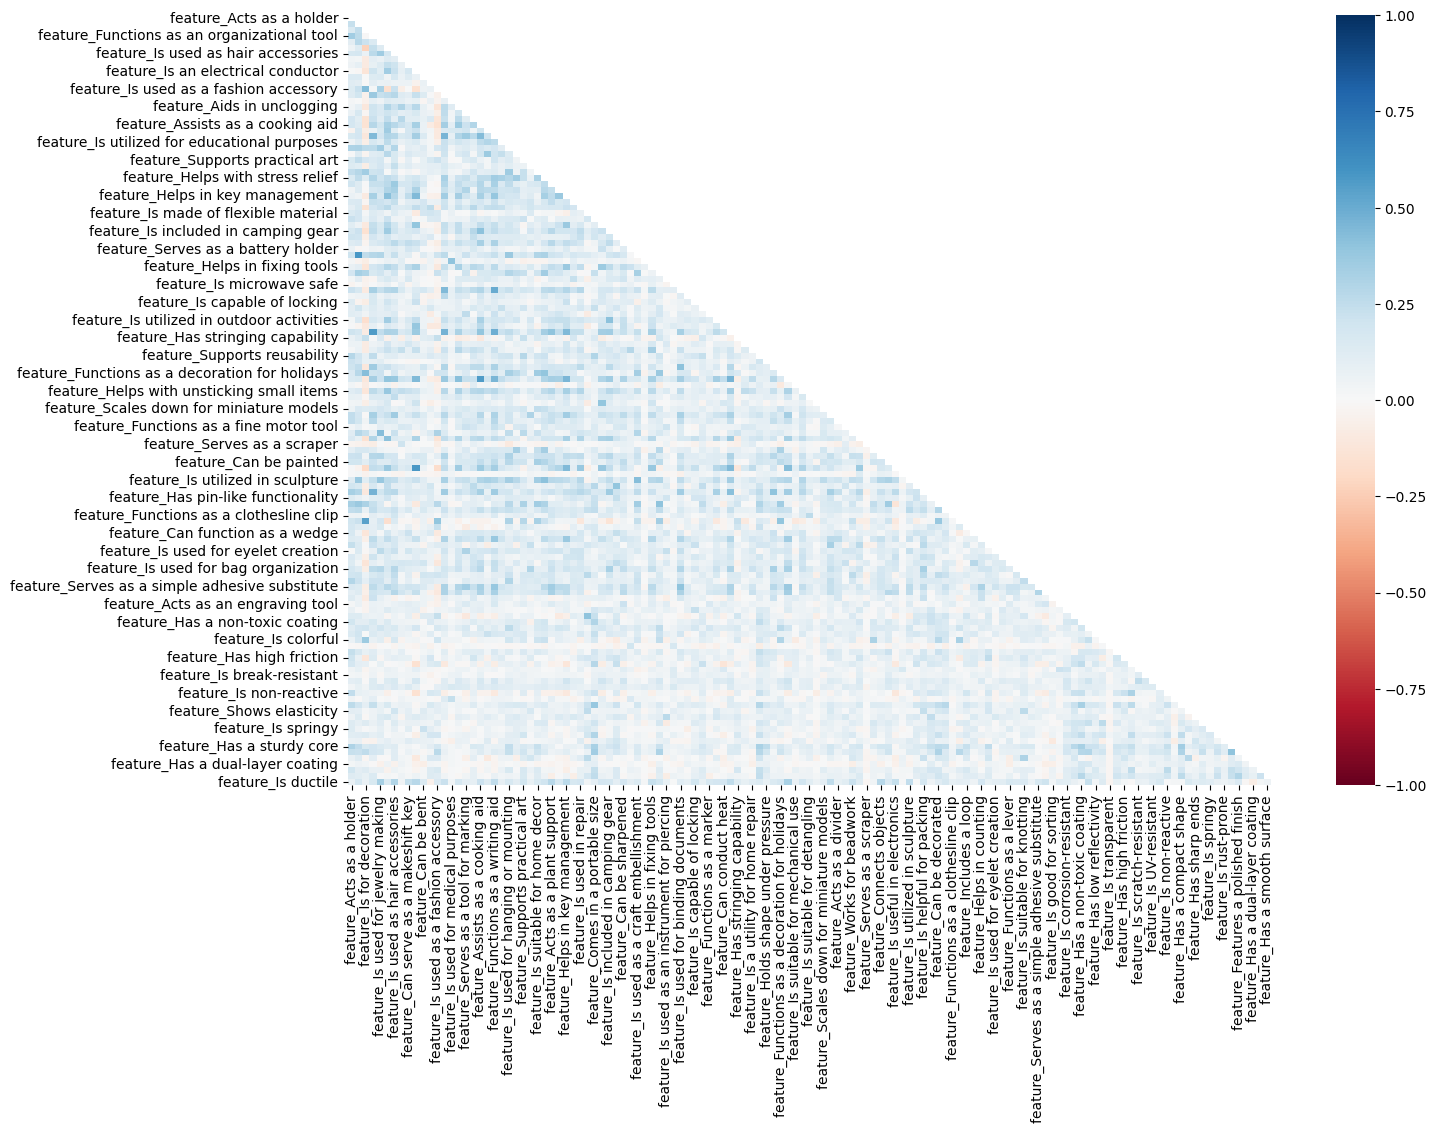

In [10]:
def correlation_matrix(df):
    correlation_matrix = df.corr()
    mask = np.triu(np.ones(correlation_matrix.shape), k=1)  # Upper triangle mask
    corr = correlation_matrix.where(mask == 0)
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, annot=False, cmap='RdBu', fmt=".1f", mask=np.triu(np.ones_like(corr, dtype=bool)), vmin=-1, vmax=1)
    plt.show()
    return correlation_matrix

vf_featuredf_corr = correlation_matrix(vf_featuredf)
autbrick_featuredf_corr = correlation_matrix(autbrick_featuredf)
autpaperclip_featuredf_corr = correlation_matrix(autpaperclip_featuredf)

In [11]:
# % of correlated features (greater than 0.5 corr)
print(np.mean(vf_featuredf_corr > 0.5),
np.mean(autbrick_featuredf_corr > 0.5),
np.mean(autpaperclip_featuredf_corr > 0.5))

# % of correlated features (less than -0.5 corr)
print(np.mean(vf_featuredf_corr < -0.5),
np.mean(autbrick_featuredf_corr < -0.5),
np.mean(autpaperclip_featuredf_corr < -0.5))

0.011966023932047863 0.009112426035502958 0.008402366863905325
0.000496000992001984 0.0 0.0


In [12]:
def get_highly_correlated_columns(corr, threshold=0.75):
    # List to store highly correlated columns
    highly_correlated = {}
    
    # can change the logic to only keep correlated columns that as least correlated with others
    # if (np.sum(vf_featuredf_corr.loc["feature_Is mammal"].values) - 1)/(len(vf_featuredf_corr.loc["feature_Is mammal"].values) - 1)

    for i, col in enumerate(corr.columns):
        for prev_col in corr.columns[:i]:  # Check only previous columns
            if abs(corr.loc[col, prev_col]) >= threshold:  # Check correlation
                highly_correlated[col] = prev_col
                break
    
    return highly_correlated

high_corr_columns_vf = get_highly_correlated_columns(vf_featuredf_corr)
high_corr_columns_autbrick = get_highly_correlated_columns(autbrick_featuredf_corr)
high_corr_columns_autpaperclip = get_highly_correlated_columns(autpaperclip_featuredf_corr)

In [13]:
remove_columns_vf = [col for col in vf_featuredf.columns if vf_featuredf[col].mean() < 0.1 or vf_featuredf[col].mean() > 0.7]
print(remove_columns_vf)
# remove_columns_vf.extend(["feature_Has tail", "feature_Has specialized hunting techniques", "feature_Is known for intelligence", "feature_Is territorial", "feature_Produces pheromones for communication", "feature_Lives symbiotically with other species", "feature_Displays mating rituals", "feature_Exhibits territorial marking", "feature_Uses specific vocalizations to communicate", "feature_Is a flagship species (conservation symbol)"])
remove_columns_vf.extend(list(high_corr_columns_vf.keys()))
print(list(high_corr_columns_vf.keys()))
vf_featuredf = vf_featuredf.drop(columns = remove_columns_vf)
vf_featurecols = [item for item in vf_featurecols if item not in remove_columns_vf]

remove_columns_autbrick = [col for col in autbrick_featuredf.columns if autbrick_featuredf[col].mean() < 0.1 or autbrick_featuredf[col].mean() > 0.7]
print(remove_columns_autbrick)
remove_columns_autbrick.extend(list(high_corr_columns_autbrick.keys()))
print(list(high_corr_columns_autbrick.keys()))
autbrick_featuredf = autbrick_featuredf.drop(columns = remove_columns_autbrick)
autbrick_featurecols = [item for item in autbrick_featurecols if item not in remove_columns_autbrick]

remove_columns_autpaperclip = [col for col in autpaperclip_featuredf.columns if autpaperclip_featuredf[col].mean() < 0.1 or autpaperclip_featuredf[col].mean() > 0.7]
print(remove_columns_autpaperclip)
remove_columns_autpaperclip.extend(list(high_corr_columns_autpaperclip.keys()))
print(list(high_corr_columns_autpaperclip.keys()))
autpaperclip_featuredf = autpaperclip_featuredf.drop(columns = remove_columns_autpaperclip)
autpaperclip_featurecols = [item for item in autpaperclip_featurecols if item not in remove_columns_autpaperclip]

['feature_Is amphibian', 'feature_Has horns', 'feature_Has antlers', 'feature_Has tusks', 'feature_Can swim', 'feature_Lives underground', 'feature_Has a long neck', 'feature_Has social hierarchy', 'feature_Shows intelligence', 'feature_Has stripes', 'feature_Is endangered', 'feature_Is found in zoos', 'feature_Has echolocation', 'feature_Is cold-blooded', 'feature_Has a specialized diet', 'feature_Can hibernate', 'feature_Has a backbone', 'feature_Is marsupial', 'feature_Is monotreme', 'feature_Is a scavenger', 'feature_Is native to South America', 'feature_Is native to Australia', 'feature_Is found in deserts', 'feature_Has a mane', 'feature_Has gills', 'feature_Is bioluminescent', 'feature_Is used in scientific research', 'feature_Is capable of parental care', 'feature_Is a pollinator', 'feature_Exhibits seasonal color changes', 'feature_Is a parasite', 'feature_Is a host for parasites', 'feature_Has specialized courtship behavior', 'feature_Is associated with mythology or folklore'

In [14]:
print(len(vf_featurecols), len(autbrick_featurecols), len(autpaperclip_featurecols))

84 111 97


## Add features to responses

In [15]:
def add_features_to_responsedf(df, task, featurecols):
    featuredict = pk.load(open(f"{task}_features.pk", "rb"))
    mapped_features = df['response'].map(featuredict)
    mapped_features = mapped_features.apply(lambda x: x if isinstance(x, dict) else {})
    fc = pd.DataFrame(mapped_features.tolist())
    df = pd.concat([df, fc], axis=1)
    df = df.replace({'True': 1, 'True.': 1, 'False': 0, 'False.': 0})
    for col in featurecols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=featurecols)
    if task == "vf":
        to_remove = ["dog cat monkey rat mouse hamster crocodile lion zebra giraffe elephant beaver hare rabbit parrot heron duck", "cow bull chicken dog cat shepherd", "cat dog lion tiger parrot monkey human food cows milk eggs hamster", "monkey dog cat guinea pig rabbit horsecow duck goat chicken elephant giraffe meerkat", " store", "tit", "python", "mammal", "le", "okay", "sea animals", "land animals", "mammals", "diversity", "birds", "unicorn", "dragon", "bird", "man", "pets"]
        df = df[~df["response"].isin(to_remove)]
    return df

data_vf = add_features_to_responsedf(data_vf, "vf", vf_featurecols)
data_autbrick = add_features_to_responsedf(data_autbrick, "autbrick", autbrick_featurecols)
data_autpaperclip = add_features_to_responsedf(data_autpaperclip, "autpaperclip", autpaperclip_featurecols)

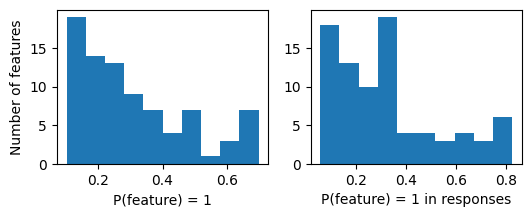

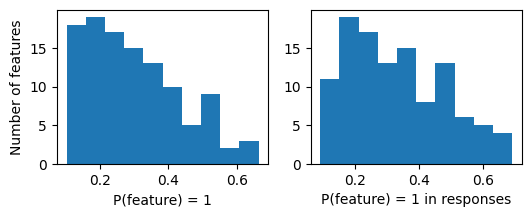

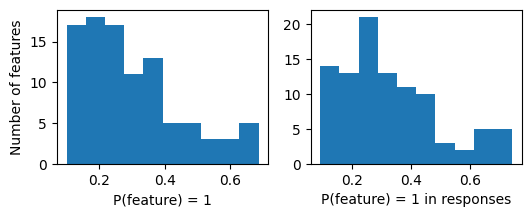

In [16]:
def plot_means(df, featuredf, featurecols):
    fig, ax = plt.subplots(1, 2, figsize=(6,2))
    ax[0].hist(featuredf.mean(axis=0).values);
    ax[0].set_xlabel("P(feature) = 1")
    ax[0].set_ylabel("Number of features")
    ax[1].hist(df[featurecols].mean(axis=0).values);
    ax[1].set_xlabel("P(feature) = 1 in responses")

plot_means(data_vf, vf_featuredf, vf_featurecols)
plot_means(data_autbrick, autbrick_featuredf, autbrick_featurecols)
plot_means(data_autpaperclip, autpaperclip_featuredf, autpaperclip_featurecols)

In [ ]:
def find_consecutive_ones(df, feature_col):
    # result = {}
    counts = {}
    for subject in df["pid"].unique():
        subject_data = df[df["pid"] == subject][feature_col].values
        # counts = {}
        current_count = 0
        for value in subject_data:
            if value == 1:
                current_count += 1
            elif current_count > 0:
                counts[current_count] = counts.get(current_count, 0) + 1
                current_count = 0
        # Add the last streak if it ends with a 1
        if current_count > 0:
            counts[current_count] = counts.get(current_count, 0) + 1 
        # result[subject] = counts
    # return result
    return counts

def make_persistance_plots(df, featuredf, featurecols):
    for col in featurecols:
        plt.figure(figsize = (2,2))
        p = df[featurecols].mean(axis=0).loc[col]   # response df
        p_ = featuredf.mean(axis=0).loc[col]        # feature df
        
        print(col, p, p_)

        fco = dict(sorted(find_consecutive_ones(df, col).items()))
        plt.plot(list(fco.keys()), np.array(list(fco.values())) / (np.sum(list(fco.values()))), label = "Data")
        
        x = np.arange(1, list(fco.keys())[-1] + 1)
        geometric_pdf = (p ** x) * (1 - p) 
        plt.plot(x, geometric_pdf, label = "Random")
        
        plt.legend()
        plt.show()

def make_persistance_plots_conditional(df, featuredf, featurecols):
    for col in featurecols:
        plt.figure(figsize = (2,2))
        p = df[featurecols].mean(axis=0).loc[col]   # response df
        p_ = featuredf.mean(axis=0).loc[col]        # feature df
        
        print(col, p, p_)

        fco = dict(sorted(find_consecutive_ones(df, col).items()))
        print(fco)
        plt.plot(list(fco.keys()), np.array(list(fco.values())) / (np.sum(list(fco.values()))), label = "Data")
        
        x = np.array(list(fco.keys()))
        # x = np.arange(1, list(fco.keys())[-1] + 1)
        geometric_pdf = (p ** (x - 1)) * (1 - p) 
        plt.plot(x, geometric_pdf, label = "Random")
        
        plt.legend()
        plt.show()

def make_persistance_plots_hazard(df, featuredf, featurecols):
    for col in featurecols:
        plt.figure(figsize = (2,2))
        p = df[featurecols].mean(axis=0).loc[col]   # response df
        p_ = featuredf.mean(axis=0).loc[col]        # feature df
        
        print(col, p, p_)

        fco = dict(sorted(find_consecutive_ones(df, col).items()))

        remaining_population = sum(fco.values())
        hazard_function = []

        for i, freq_i in fco.items():
            hazard_function.append(freq_i / remaining_population)  # Hazard probability for i
            remaining_population -= freq_i

        plt.plot(list(fco.keys()), hazard_function, label = "Data")
        
        x = np.arange(1, list(fco.keys())[-1] + 1)
        geometric_pdf = [(1 - p)] * len(x)
        plt.plot(x, geometric_pdf, label = "Random")
        
        plt.legend()
        plt.show()

feature_Is mammal 0.6427532719340766 0.4763092269326683
{1: 238, 2: 207, 3: 158, 4: 109, 5: 84, 6: 67, 7: 49, 8: 30, 9: 25, 10: 22, 11: 13, 12: 10, 13: 7, 14: 4, 15: 1, 16: 2, 17: 2, 18: 2, 19: 1, 20: 1}


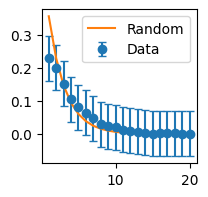

feature_Is bird 0.12813055420908062 0.20199501246882792
{1: 307, 2: 86, 3: 42, 4: 17, 5: 11, 6: 5, 7: 1, 8: 1, 9: 1, 11: 1}


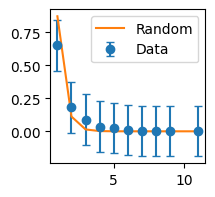

feature_Is insect 0.07658749394086282 0.11471321695760599
{1: 157, 2: 53, 3: 20, 4: 12, 5: 10, 6: 5, 7: 2, 9: 1}


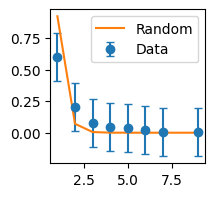

feature_Is reptile 0.05655194700274681 0.10723192019950124
{1: 217, 2: 37, 3: 10, 4: 6, 5: 1}


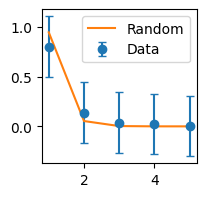

feature_Is fish 0.0664081434803684 0.11471321695760599
{1: 272, 2: 49, 3: 8, 4: 2, 9: 1}


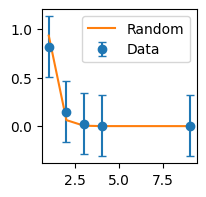

feature_Is carnivore 0.3355954112134432 0.2593516209476309
{1: 505, 2: 354, 3: 113, 4: 75, 5: 20, 6: 6, 7: 9, 8: 1, 9: 2}


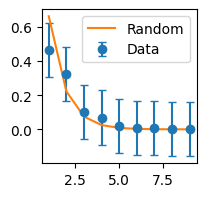

feature_Is herbivore 0.2766198093391501 0.18204488778054864
{1: 554, 2: 247, 3: 98, 4: 39, 5: 16, 6: 10, 7: 6, 8: 4}


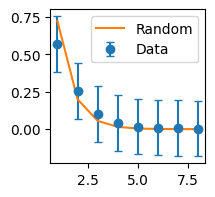

feature_Is omnivore 0.35595411213443207 0.38902743142144636
{1: 822, 2: 319, 3: 127, 4: 46, 5: 21, 6: 7, 7: 2, 8: 1, 9: 1}


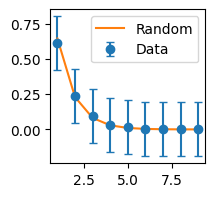

feature_Has fur 0.3947325900791727 0.2967581047381546
{1: 492, 2: 280, 3: 171, 4: 74, 5: 51, 6: 27, 7: 12, 8: 4, 9: 3, 11: 2}


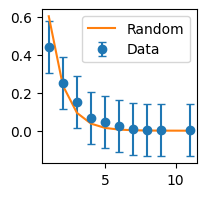

feature_Has scales 0.10890289222814671 0.11471321695760599
{1: 412, 2: 94, 3: 14, 4: 8}


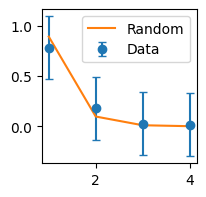

feature_Has exoskeleton 0.07739537889804492 0.10473815461346633
{1: 197, 2: 78, 3: 25, 4: 7, 5: 2, 6: 1, 7: 1}


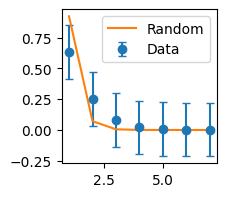

feature_Has claws 0.3543383422200679 0.3915211970074813
{1: 671, 2: 271, 3: 141, 4: 71, 5: 23, 6: 11, 7: 5, 8: 3, 9: 2, 15: 1}


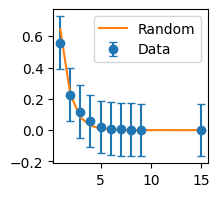

feature_Has whiskers 0.1767652286314429 0.1371571072319202
{1: 548, 2: 151, 3: 48, 4: 21, 5: 2, 6: 1}


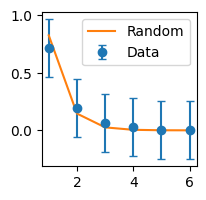

feature_Has wings 0.17191791888835029 0.18952618453865336
{1: 334, 2: 132, 3: 57, 4: 34, 5: 16, 6: 8, 7: 2, 8: 1, 9: 1}


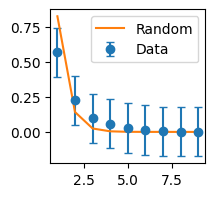

feature_Has tail 0.635967038293747 0.5311720698254364
{1: 367, 2: 281, 3: 203, 4: 118, 5: 81, 6: 60, 7: 39, 8: 31, 9: 26, 10: 13, 11: 8, 12: 4, 13: 4, 14: 4, 15: 1, 17: 1}


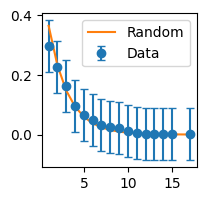

feature_Can climb 0.3722733882695104 0.38154613466334164
{1: 826, 2: 318, 3: 145, 4: 50, 5: 29, 6: 8, 7: 2}


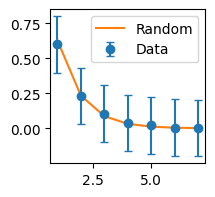

feature_Can dig 0.31378251736952656 0.3117206982543641
{1: 643, 2: 282, 3: 107, 4: 38, 5: 29, 6: 10, 7: 7, 8: 1}


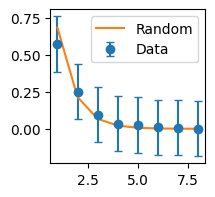

feature_Can jump 0.3506220714170302 0.2593516209476309
{1: 789, 2: 352, 3: 114, 4: 57, 5: 16, 6: 2, 7: 1, 8: 1}


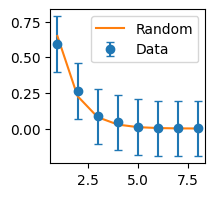

feature_Is nocturnal 0.14218775246404913 0.10723192019950124
{1: 505, 2: 114, 3: 38, 4: 7, 5: 1}


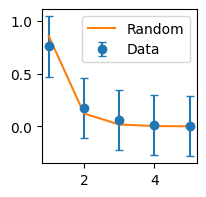

feature_Is diurnal 0.3456131846825012 0.26683291770573564
{1: 604, 2: 322, 3: 121, 4: 59, 5: 33, 6: 11, 7: 4, 8: 3, 9: 1}


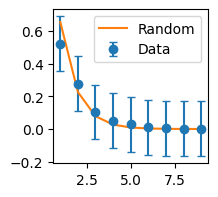

feature_Has more than four limbs 0.13200840200355468 0.12967581047381546
{1: 440, 2: 140, 3: 23, 4: 7}


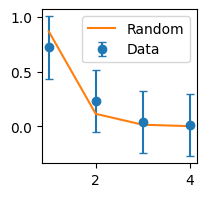

feature_Lives in water 0.1769268056228793 0.24937655860349128
{1: 341, 2: 90, 3: 57, 4: 28, 5: 23, 6: 10, 7: 4, 8: 6, 9: 2, 10: 1, 12: 1}


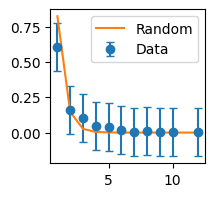

feature_Lives in trees 0.0814348036839554 0.12468827930174564
{1: 368, 2: 48, 3: 8, 5: 2, 6: 1}


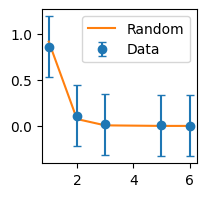

feature_Lives on land 0.7348521570528357 0.600997506234414
{1: 237, 2: 156, 3: 120, 4: 79, 5: 84, 6: 58, 7: 53, 8: 47, 9: 34, 10: 27, 11: 24, 12: 25, 13: 12, 14: 8, 15: 8, 16: 3, 17: 4, 18: 2, 19: 2, 21: 1, 23: 3}


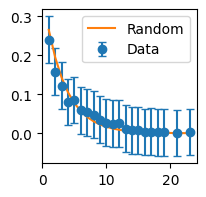

feature_Lays eggs 0.28195185005655193 0.3341645885286783
{1: 587, 2: 197, 3: 94, 4: 45, 5: 30, 6: 11, 7: 4, 8: 5, 9: 2}


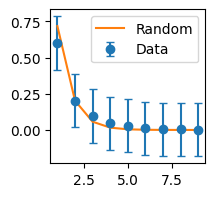

feature_Gives birth 0.28599127484246245 0.2344139650872818
{1: 605, 2: 264, 3: 126, 4: 34, 5: 12, 6: 7, 7: 3}


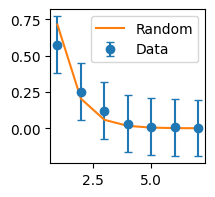

feature_Is venomous 0.07691064792373566 0.10224438902743142
{1: 270, 2: 57, 3: 24, 4: 2, 5: 1, 7: 1}


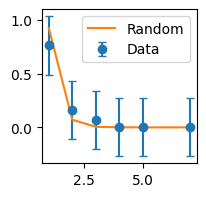

feature_Is domesticated 0.3157214412667636 0.18703241895261846
{1: 352, 2: 206, 3: 120, 4: 83, 5: 37, 6: 24, 7: 10, 8: 6, 9: 2, 10: 1, 11: 1, 12: 1}


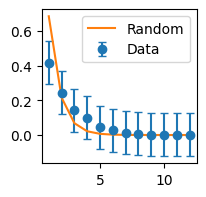

feature_Lives in groups 0.32880917757311356 0.3491271820448878
{1: 808, 2: 313, 3: 107, 4: 40, 5: 11, 6: 6, 7: 3, 8: 1}


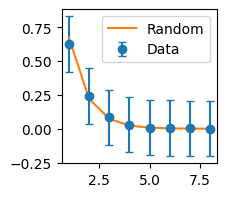

feature_Is solitary 0.3328486023590241 0.36658354114713215
{1: 960, 2: 301, 3: 90, 4: 33, 5: 10, 6: 3, 7: 4}


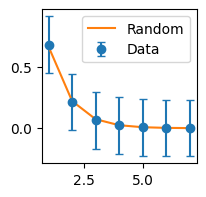

feature_Builds nests 0.23978025529164648 0.26433915211970077
{1: 688, 2: 169, 3: 79, 4: 28, 5: 13, 6: 5, 7: 2}


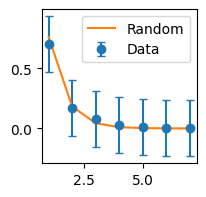

feature_Is migratory 0.1412182905154306 0.1770573566084788
{1: 435, 2: 127, 3: 36, 4: 8, 5: 6, 6: 1, 9: 1}


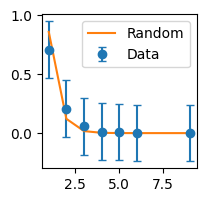

feature_Uses tools 0.19324608175795766 0.19451371571072318
{1: 628, 2: 135, 3: 45, 4: 23, 5: 10, 6: 1, 7: 1, 8: 1}


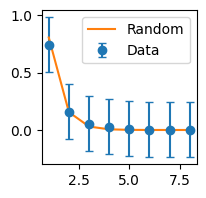

feature_Communicates vocally 0.3255776377443852 0.27680798004987534
{1: 695, 2: 322, 3: 103, 4: 36, 5: 14, 6: 15, 7: 5, 9: 2, 10: 1}


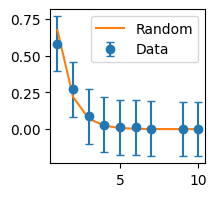

feature_Has camouflage 0.27209565357893034 0.40399002493765584
{1: 616, 2: 234, 3: 93, 4: 40, 5: 9, 6: 8, 7: 6, 8: 1, 9: 2}


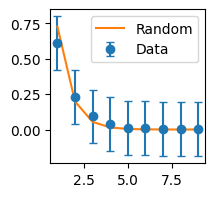

feature_Has spots 0.12554532234609792 0.12468827930174564
{1: 505, 2: 96, 3: 20, 4: 5}


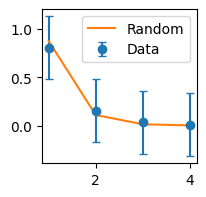

feature_Can change color 0.08612053643561157 0.15211970074812967
{1: 336, 2: 62, 3: 14, 4: 4, 5: 3}


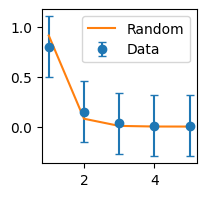

feature_Is commonly kept as a pet 0.3517531103570852 0.2194513715710723
{1: 533, 2: 285, 3: 124, 4: 77, 5: 40, 6: 17, 7: 7, 8: 3, 9: 1, 10: 1}


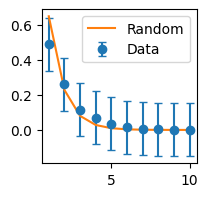

feature_Is used in farming 0.31378251736952656 0.2892768079800499
{1: 562, 2: 197, 3: 96, 4: 67, 5: 40, 6: 19, 7: 6, 8: 7, 9: 2}


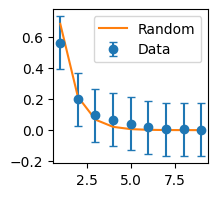

feature_Is hunted by humans 0.7325900791727258 0.6982543640897756
{1: 282, 2: 222, 3: 187, 4: 129, 5: 90, 6: 64, 7: 53, 8: 34, 9: 20, 10: 18, 11: 12, 12: 16, 13: 15, 14: 6, 15: 7, 16: 3, 17: 1, 18: 3, 20: 1, 22: 1, 25: 1}


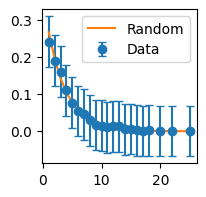

feature_Is used for food by humans 0.5071901761189207 0.43640897755610975
{1: 596, 2: 296, 3: 183, 4: 109, 5: 68, 6: 40, 7: 26, 8: 10, 9: 4, 10: 4, 11: 1, 12: 2, 13: 1}


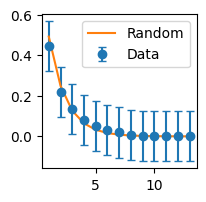

feature_Is capable of mimicry 0.12392955243173372 0.18204488778054864
{1: 489, 2: 81, 3: 29, 4: 6, 5: 1}


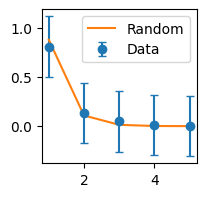

feature_Is warm-blooded 0.33947325900791725 0.2743142144638404
{1: 648, 2: 342, 3: 140, 4: 51, 5: 24, 6: 3, 7: 1}


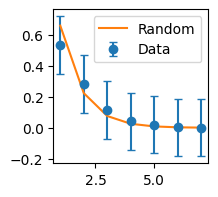

feature_Has a long lifespan 0.11811278074002263 0.10972568578553615
{1: 476, 2: 111, 3: 11}


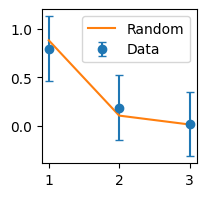

feature_Is capable of regrowth 0.48376151236063986 0.49875311720698257
{1: 649, 2: 344, 3: 181, 4: 107, 5: 42, 6: 31, 7: 21, 8: 9, 9: 2, 10: 3, 11: 1, 12: 1}


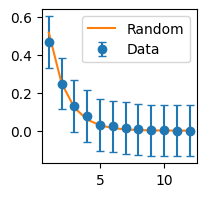

feature_Has specialized hunting techniques 0.7195023428663758 0.683291770573566
{1: 282, 2: 216, 3: 168, 4: 140, 5: 99, 6: 70, 7: 39, 8: 43, 9: 19, 10: 19, 11: 14, 12: 9, 13: 13, 14: 10, 15: 4, 16: 2, 17: 2, 19: 1, 20: 2, 26: 1}


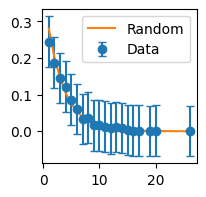

feature_Is known for speed 0.22895459686540637 0.2194513715710723
{1: 690, 2: 213, 3: 66, 4: 19, 5: 3, 6: 2}


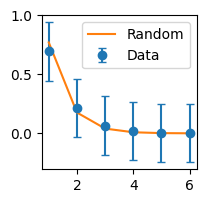

feature_Is known for strength 0.5558248505412829 0.47381546134663344
{1: 649, 2: 314, 3: 217, 4: 128, 5: 65, 6: 37, 7: 23, 8: 16, 9: 7, 10: 3, 11: 3, 12: 1, 13: 2}


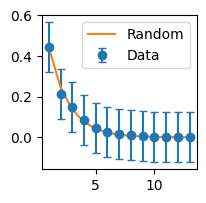

feature_Is placental 0.3894005493617709 0.27680798004987534
{1: 555, 2: 268, 3: 158, 4: 82, 5: 42, 6: 19, 7: 13, 8: 8, 9: 3, 11: 1}


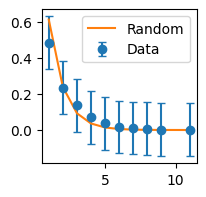

feature_Is flightless 0.1984165454839231 0.1546134663341646
{1: 784, 2: 152, 3: 44, 4: 2}


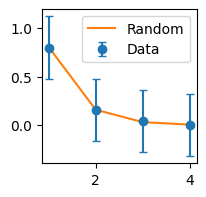

feature_Has webbed feet 0.13911778962675714 0.12718204488778054
{1: 418, 2: 101, 3: 41, 4: 16, 5: 6, 6: 4}


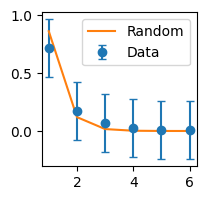

feature_Is known for intelligence 0.8125706899337535 0.6483790523690773
{1: 186, 2: 128, 3: 103, 4: 86, 5: 65, 6: 63, 7: 53, 8: 56, 9: 31, 10: 41, 11: 19, 12: 18, 13: 16, 14: 17, 15: 7, 16: 11, 17: 8, 18: 1, 19: 2, 20: 1, 21: 3, 22: 3, 23: 3, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 31: 1}


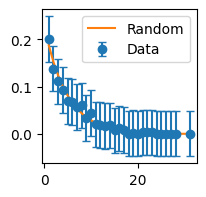

feature_Is territorial 0.7558571659395702 0.685785536159601
{1: 242, 2: 212, 3: 137, 4: 138, 5: 86, 6: 58, 7: 60, 8: 37, 9: 28, 10: 30, 11: 27, 12: 12, 13: 8, 14: 8, 15: 10, 16: 4, 17: 1, 18: 3, 19: 1, 21: 2}


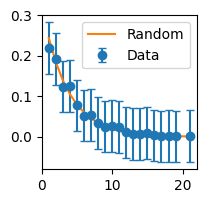

feature_Is native to Africa 0.16480853126514786 0.1172069825436409
{1: 450, 2: 157, 3: 52, 4: 13, 5: 6, 6: 3}


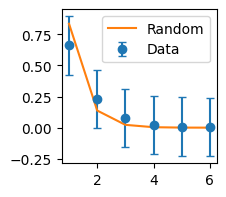

feature_Is native to Asia 0.23541767652286313 0.23690773067331672
{1: 798, 2: 207, 3: 52, 4: 16, 5: 5}


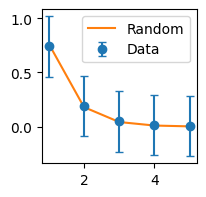

feature_Is native to North America 0.07481014703506221 0.1172069825436409


KeyboardInterrupt: 

<Figure size 200x200 with 0 Axes>

In [18]:
make_persistance_plots_conditional(data_vf, vf_featuredf, vf_featurecols)

In [ ]:
make_persistance_plots_hazard(data_vf, vf_featuredf, vf_featurecols)

In [ ]:
make_persistance_plots_conditional(data_autbrick, autbrick_featuredf, autbrick_featurecols)

In [ ]:
make_persistance_plots_hazard(data_autbrick, autbrick_featuredf, autbrick_featurecols)

In [ ]:
# def get_jump(df, featurecols):
#     df["jump"] = None
#     df = df.groupby('pid', group_keys=False).apply(compute_jump, featurecols = featurecols)
#     return df

# def compute_jump(group, featurecols):
#     group = group.copy()  # Avoid modifying the original DataFrame
#     group['jump'] = np.nan
#     group.iloc[0, group.columns.get_loc('jump')] = 1  # First jump in each group is always 1

#     for i in range(1, len(group)):
#         # Check for NaN values in either row
#         if group.iloc[i - 1][featurecols].isnull().any() or group.iloc[i][featurecols].isnull().any():
#             group.iloc[i, group.columns.get_loc('jump')] = np.nan
#         else:
#             # Check for consecutive 1s in any feature column
#             consecutive_ones = (group.iloc[i - 1][featurecols] == 1) & (group.iloc[i][featurecols] == 1)
#             if consecutive_ones.any():
#                 group.iloc[i, group.columns.get_loc('jump')] = 0
#             else:
#                 group.iloc[i, group.columns.get_loc('jump')] = 1
#     return group

# data_vf = get_jump(data_vf, vf_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same'] = None
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols = featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    num_features_same = [np.nan]  # Initialize with nan for the first row
    
    for i in range(1, len(group)):
        row1 = group.loc[i - 1, featurecols]
        row2 = group.loc[i, featurecols]
        
        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same.append(np.nan)
        else:
            consecutive_1s = (row1 == 1) & (row2 == 1)
            num_features_same.append(consecutive_1s.sum())
    
    group['num_features_same'] = num_features_same
    return group

data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
plt.hist(data_vf["num_features_same"], alpha=0.3, label="vf");
plt.hist(data_autbrick["num_features_same"], alpha=0.3, label="autbrick");
plt.hist(data_autpaperclip["num_features_same"], alpha=0.3, label="autpaperclip");
plt.legend();

In [ ]:
data_vf = data_vf[(data_vf["order"] > 0) & (data_vf["order"] < 20)]
data_autbrick = data_autbrick[(data_autbrick["order"] > 0) & (data_autbrick["order"] < 20)]
data_autpaperclip = data_autpaperclip[(data_autpaperclip["order"] > 0) & (data_autpaperclip["order"] < 20)]

In [ ]:
data_humans = pd.read_csv("../csvs/data_humans.csv")

In [ ]:
data_vf = pd.merge(data_vf, data_humans[data_humans["task"] == 1].drop("Unnamed: 0", axis=1), on=['pid', 'task', 'starttime', 'endtime', 'original_response_Dutch',
       'original_response', 'original_response_cleaned', 'response', 'invalid', 'response_len', 'response_num_words', 'previous_original_response', 'previous_response', 'order', 'RT'], how='outer')
data_autbrick = pd.merge(data_autbrick, data_humans[data_humans["task"] == 2].drop("Unnamed: 0", axis=1), on=['pid', 'task', 'starttime', 'endtime', 'original_response_Dutch',
       'original_response', 'original_response_cleaned', 'response', 'invalid', 'response_len', 'response_num_words', 'previous_original_response', 'previous_response', 'order', 'RT'], how='outer')
data_autpaperclip = pd.merge(data_autpaperclip, data_humans[data_humans["task"] == 3].drop("Unnamed: 0", axis=1), on=['pid', 'task', 'starttime', 'endtime', 'original_response_Dutch',
       'original_response', 'original_response_cleaned', 'response', 'invalid', 'response_len', 'response_num_words', 'previous_original_response', 'previous_response', 'order', 'RT'], how='outer')

In [ ]:
plt.figure()
plt.scatter(data_vf["SS"], data_vf["num_features_same"], alpha = 0.3)
print(np.corrcoef(data_vf["SS"], data_vf["num_features_same"]))
plt.xlabel("SS")
plt.ylabel("Number of features same");
plt.figure()
plt.scatter(data_autbrick["SS"], data_autbrick["num_features_same"])
plt.xlabel("SS")
plt.ylabel("Number of features same");
plt.figure()
plt.scatter(data_autpaperclip["SS"], data_autpaperclip["num_features_same"])
plt.xlabel("SS")
plt.ylabel("Number of features same");

In [ ]:
# least similar
print(data_vf[["response", "previous_response", "num_features_same", "SS", "jump"]][data_vf["num_features_same"] < 10]["SS"].mean())
data_vf[["response", "previous_response", "num_features_same", "SS", "jump"]][data_vf["num_features_same"] < 10].drop_duplicates().head(50)

In [ ]:
# most similar
print(data_vf[["response", "previous_response", "num_features_same", "SS", "jump"]][data_vf["num_features_same"] > 15]["SS"].mean())
data_vf[["response", "previous_response", "num_features_same", "SS", "jump"]][data_vf["num_features_same"] > 15].drop_duplicates().sort_values(by=["num_features_same"], ascending=False).head(50)

In [ ]:
# plt.scatter(data_vf[["pid", "jump_profile"]].groupby("pid").max().reset_index()["jump_profile"].values, data_vf[["pid", "num_features_same"]].groupby("pid").mean()["num_features_same"].values)
plt.figure()
plt.scatter(np.arange(219), pd.merge(data_vf[["pid", "num_features_same"]].groupby("pid").mean().reset_index(), data_vf[["pid", "jump_profile"]].groupby("pid").max().reset_index(), on=["pid"]).sort_values("jump_profile")["num_features_same"])
plt.xlabel("Max jump profile")
plt.ylabel("Mean features same");
plt.figure()
t = pd.merge(data_autbrick[["pid", "num_features_same"]].groupby("pid").mean().reset_index(), data_autbrick[["pid", "jump_profile"]].groupby("pid").max().reset_index(), on=["pid"]).sort_values("jump_profile")["num_features_same"]
plt.scatter(np.arange(len(t)), t)
plt.xlabel("Max jump profile")
plt.ylabel("Mean features same");
plt.figure()
t = pd.merge(data_autpaperclip[["pid", "num_features_same"]].groupby("pid").mean().reset_index(), data_autpaperclip[["pid", "jump_profile"]].groupby("pid").max().reset_index(), on=["pid"]).sort_values("jump_profile")["num_features_same"]
plt.scatter(np.arange(len(t)), t)
plt.xlabel("Max jump profile")
plt.ylabel("Mean features same");

In [ ]:
def plot_binary_features_heatmap(df, featurecols):
    pids = df["pid"].unique()
    cnt = 1
    for pid in pids:
        responses = df[df["pid"] == pid]["response"].values
        pid_data = df[df["pid"] == pid][featurecols].reset_index(drop=True)
        
        plt.figure(figsize=(25, len(pid_data) * 0.25))
        sns.heatmap(
            pid_data,
            cmap=sns.color_palette(["white", "green"]),
            cbar=False,
            linewidths=0.5,
            linecolor='black'
        )
        plt.title(f"Binary Features Heatmap for PID {pid}")
        plt.gca().xaxis.tick_top()
        plt.xticks(ticks=np.arange(len(featurecols)) + 0.5, labels=featurecols, rotation=90)
        plt.yticks(ticks=np.arange(len(responses)) + 0.5, labels=responses, rotation=0)
        plt.show()
        
        if cnt == 10:
            break
        cnt += 1

In [ ]:
plot_binary_features_heatmap(data_vf, vf_featurecols)

In [ ]:
plot_binary_features_heatmap(data_autbrick, autbrick_featurecols)

In [ ]:
plot_binary_features_heatmap(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
# Few vs many dimensions
# How persistant are different dimensions? Compared to random
# How correlated are different dimensions? Can help decrease #dims
# Transitions between different dimensions? 

# avg_num_features_same vs jump_profile